In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
# from spikingjelly.clock_driven import functional, surrogate, neuron, layer
from spikingjelly.activation_based import spike_op as sn
from spikingjelly.activation_based import functional, surrogate, neuron, layer, encoding
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import os
import time
import torchmetrics
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from torchinfo import summary
np.int = int
save_dir = './model_checkpoints'
os.makedirs(save_dir, exist_ok=True)

c:\Users\SHAURYAM DUBEY\Documents\.repo-github\csnn\venv\lib\site-packages\spikingjelly\activation_based\spike_op.py:84: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, spike, weight, bias, stride, padding, dilation, groups):
c:\Users\SHAURYAM DUBEY\Documents\.repo-github\csnn\venv\lib\site-packages\spikingjelly\activation_based\spike_op.py:110: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_output):
c:\Users\SHAURYAM DUBEY\Documents\.repo-github\csnn\venv\lib\site-packages\spikingjelly\activation_based\spike_op.py:152: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, spike, weight, bias=None):
c:\Users\SHAURYAM DUBEY\Documents\.repo-github\csnn\venv\lib\s

In [2]:
time_steps = 8
batch_size = 16
learning_rate = 1e-3
epochs = 100

transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((48, 48)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.99], std=[0.99])
])

# Load the dataset
train_dataset = datasets.ImageFolder(
    root='./dataset/data/train', transform=transform)
test_dataset = datasets.ImageFolder(
    root='./dataset/data/test', transform=transform)
valid_dataset = datasets.ImageFolder(
    root='./dataset/data/valid', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False,drop_last=True)

# Define device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [43]:
for i , (data, target) in enumerate(train_loader):
    print(i, data, target)
    break

0 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.8196, 0.8078, 0.7725,  ..., 0.2824, 0.2706, 0.2706],
          [0.8078, 0.7961, 0.7725,  ..., 0.2824, 0.2667, 0.2863],
          [0.8078, 0.7647, 0.7490,  ..., 0.4235, 0.3647, 0.3451],
          ...,
          [0.3137, 0.2000, 0.0980,  ..., 0.8235, 0.3765, 0.0667],
          [0.3137, 0.2941, 0.1804,  ..., 0.7922, 0.3137, 0.0902],
          [0.1804, 0.2706, 0.2824,  ..., 0.8118, 0.4000, 0.1020]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.3059, 0.3843, 0.0000],
          [0.2353, 0.1020, 0.1294,  ..., 0.2627, 0.3490, 0.0000],
          [0.2157, 0.2039, 0.2353,  

In [3]:
class CSNN(nn.Module):
    def __init__(self, T=8):
        super(CSNN, self).__init__()
        self.T = T
        self.layer1 = nn.Sequential(
            layer.Conv2d(1, 128, kernel_size=3, stride=1,
                         padding=1, step_mode='s'),
            layer.BatchNorm2d(128, step_mode='s'),
        )
        self.layer2 = nn.Sequential(
            neuron.IFNode(v_threshold=1.0,
                          surrogate_function=surrogate.ATan(), step_mode='m'),
            layer.MaxPool2d(kernel_size=2, stride=2),
            layer.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            layer.BatchNorm2d(128),
            neuron.IFNode(v_threshold=1.0,
                          surrogate_function=surrogate.ATan(), step_mode='m'),
            layer.MaxPool2d(kernel_size=2)
        )
        self.layer3 = nn.Sequential(
            layer.Flatten(),
            layer.Dropout(p=0.5),
            layer.Linear(128*12*12, 1152),
            neuron.LIFNode(tau=2.0, v_reset=0.0,
                           surrogate_function=surrogate.ATan(), step_mode='m'),
            layer.Dropout(p=0.5),
            layer.Linear(1152, 128),
            neuron.LIFNode(tau=2.0, v_reset=0.0,
                           surrogate_function=surrogate.ATan(), step_mode='m'),
            layer.Linear(128, 7),
            neuron.LIFNode(tau=2.0, v_reset=0.0,
                           surrogate_function=surrogate.ATan(), step_mode='m')
        )

        functional.set_step_mode(self.layer2, step_mode='m')
        functional.set_step_mode(self.layer3, step_mode='m')
        functional.set_backend(self, backend='cupy')
        self.pe = encoding.PoissonEncoder()

    def forward(self, x):
        # x = self.pe(x)
        x = self.layer1(x)
        x_step = x.unsqueeze(0).repeat(self.T, 1, 1, 1, 1)
        out1 = self.layer2(x_step)
        out2 = self.layer3(out1)
        return out2.mean(dim=0)

In [4]:
class EarlyStopping:
    def __init__(self, patience=10, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.best_acc = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, model, val_loss, val_acc):
        if self.best_acc is None or val_acc > self.best_acc:
            self.best_acc = val_acc
            self.save_best(model)
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_best(model, is_loss=True)
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
    def load_state(self, loss, acc, counter, early_stop):
        self.best_loss = loss
        self.best_acc = acc
        self.counter = counter
        self.early_stop = early_stop
    def get_state(self):
        return self.best_loss, self.best_acc, self.counter, self.early_stop
    def save_best(self, model, is_loss=False):
        torch.save(model.state_dict(), os.path.join(
            save_dir, f"best_model_{'acc' if is_loss else 'loss'}.pth"))
        
        


early_stopping = EarlyStopping(patience=10)

In [31]:
def smooth_one_hot(true_labels: torch.Tensor, classes: int, smoothing=0):
    """
    if smoothing == 0, it's one-hot method
    if 0 < smoothing < 1, it's smooth method

    """
    device = true_labels.device
    true_labels = torch.nn.functional.one_hot(
        true_labels, classes).detach().cuda()
    assert 0 <= smoothing < 1
    confidence = 1.0 - smoothing
    label_shape = torch.Size((true_labels.size(0), classes))
    with torch.no_grad():
        true_dist = torch.empty(
            size=label_shape, device=true_labels.device)
        true_dist.fill_(smoothing / (classes - 1))
        _, index = torch.max(true_labels, 1)

        index = torch.tensor(index.unsqueeze(1).clone().detach(),dtype=torch.int64, device=device)
        true_dist.scatter_(1, index, confidence).to(device)
    return true_dist.to(device)
  
def train(model, loader, optimizer, criterion, mse=False):
    model.train()

    total_loss, correct = 0, 0

    for data, target in loader:

        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)

        if mse:

          # target_onehot = torch.nn.functional.one_hot(

          #     target, num_classes=7).float()

          target_onehot = smooth_one_hot(target, classes=7,smoothing=0)
          loss = criterion(output, target_onehot)

        else:
          loss = criterion(output, target)

        loss.backward()

        optimizer.step()

        total_loss += loss.item() * data.size(0)

        correct += (output.argmax(dim=1) == target).sum().item()

        functional.reset_net(model)  # Reset neuron states

    return total_loss / len(loader.dataset), correct / len(loader.dataset)



def validate(model, loader, criterion, mse=False):

    model.eval()

    total_loss, correct = 0, 0

    with torch.no_grad():

        for data, target in loader:

            data, target = data.to(device), target.to(device)
            output = model(data)

            if mse:

              target_onehot = smooth_one_hot(target, classes=7, smoothing=0)

              # target_onehot = torch.nn.functional.one_hot(target, num_classes=7).float()
              loss = criterion(output, target_onehot)

            else:
              loss = criterion(output, target)

            total_loss += loss.item() * data.size(0)

            correct += (output.argmax(dim=1) == target).sum().item()

            functional.reset_net(model)  # Reset neuron states

    return total_loss / len(loader.dataset), correct / len(loader.dataset)
  


def save_checkpoint(model, optimizer, early_stopping, epoch, path="./model_checkpoints/csnn_checkpoint.pth"):

    best_loss, best_acc, counter, early_stop = early_stopping.get_state()

    checkpoint = {

        'model_state_dict': model.state_dict(),

        'optimizer_state_dict': optimizer.state_dict(),

        'epoch': epoch,

        'best_loss': best_loss,

        'best_acc': best_acc,

        'counter': counter,

        'early_stop': early_stop

    }

    torch.save(checkpoint, path)

    print(f"Checkpoint saved at epoch {epoch}")



def load_checkpoint(model, optimizer, early_stopping, path="./model_checkpoints/csnn_checkpoint.pth"):

    checkpoint = torch.load(path)

    model.load_state_dict(checkpoint['model_state_dict'])

    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    epoch = checkpoint['epoch']

    early_stopping.load_state(checkpoint['best_loss'], checkpoint['best_acc'], checkpoint['counter'], checkpoint['early_stop'])

    print(f"Checkpoint loaded, resuming from epoch {epoch}")
    return epoch

In [32]:
from torchinfo import summary
model = CSNN(T=4).to(device)
summary(model, (batch_size, 1, 48, 48), col_names=["input_size","output_size","num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
CSNN                                     [16, 1, 48, 48]           [16, 7]                   --
├─Sequential: 1-1                        [16, 1, 48, 48]           [16, 128, 48, 48]         --
│    └─Conv2d: 2-1                       [16, 1, 48, 48]           [16, 128, 48, 48]         1,280
│    └─BatchNorm2d: 2-2                  [16, 128, 48, 48]         [16, 128, 48, 48]         256
├─Sequential: 1-2                        [4, 16, 128, 48, 48]      [4, 16, 128, 12, 12]      --
│    └─IFNode: 2-3                       [4, 16, 128, 48, 48]      [4, 16, 128, 48, 48]      --
│    └─MaxPool2d: 2-4                    [4, 16, 128, 48, 48]      [4, 16, 128, 24, 24]      --
│    └─Conv2d: 2-5                       [4, 16, 128, 24, 24]      [4, 16, 128, 24, 24]      147,584
│    └─BatchNorm2d: 2-6                  [4, 16, 128, 24, 24]      [4, 16, 128, 24, 24]      256
│    └─IFNode: 2-7       

In [33]:

train_acc_hist = []
val_acc_hist = []
train_loss_hist = []
val_loss_hist = []

def train_model(model, resume=False):
    # criterion = nn.CrossEntropyLoss()
    criterion = nn.MSELoss().to(device)

    mse = True if criterion._get_name() == 'MSELoss' else False

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    # Track training time
    start_time = time.time()
    # Train and Validate
    start_epoch = 1
    if resume:
        start_epoch = load_checkpoint(model, optimizer, early_stopping)
    for epoch in range(start_epoch, epochs + 20):
        train_loss, train_acc = train(
            model, train_loader, optimizer, criterion, mse=mse)
        val_loss, val_acc = validate(model, test_loader, criterion, mse=mse)
        train_acc_hist.append(train_acc)
        val_acc_hist.append(val_acc)
        train_loss_hist.append(train_loss)
        val_loss_hist.append(val_loss)
        print(f"Epoch {epoch}: Train Loss: {train_loss:.4f}, Train Acc: {100*train_acc:.4f}%, "
            f"Val Loss: {val_loss:.4f}, Val Acc: {100*val_acc:.4f}%")
        
        early_stopping(model, val_loss, val_acc)
        save_checkpoint(model, optimizer, early_stopping, epoch + 1)
        # if early_stopping.early_stop:
        #     print("Early stopping")
        #     break
        if epoch % 30 == 0:
            break
        
    # Training time
    training_time = time.time() - start_time
    print(f"Training Time: {training_time / 60:.2f} minutes")


In [ ]:
train_model(model, resume=False)
# model_data = {
#   "tloss": train_loss_hist,
#   "tacc": train_acc_hist,
#   "vloss": val_loss_hist,
#   "vacc": val_acc_hist
# }
# torch.save(model_data, './model_checkpoints/loss_acc_data.pth')

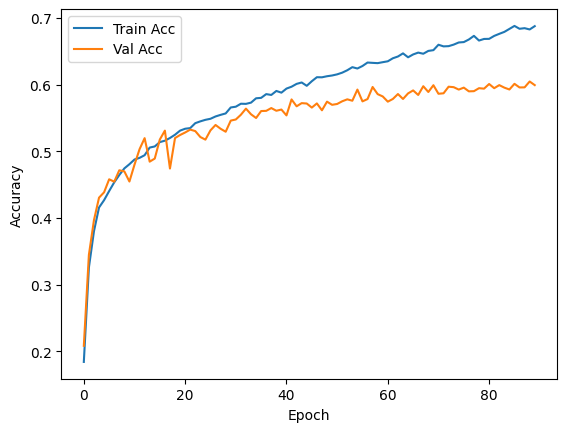

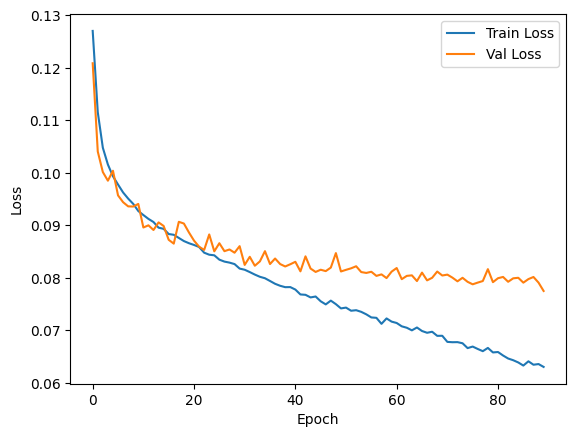

In [39]:
# plot train and validation accuracy
import matplotlib.pyplot as plt


def plot_acc(train_acc_hist, val_acc_hist):
    plt.plot(train_acc_hist, label='Train Acc')
    plt.plot(val_acc_hist, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


def plot_loss(train_loss_hist, val_loss_hist):
    plt.plot(train_loss_hist, label='Train Loss')
    plt.plot(val_loss_hist, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


plot_acc(train_acc_hist, val_acc_hist)
plot_loss(train_loss_hist, val_loss_hist)

In [40]:
print(f"max train accuracy: {100*max(train_acc_hist):.2f}%")
print(f"max validation accuracy: {100*max(val_acc_hist):.2f}%")

max train accuracy: 68.80%
max validation accuracy: 60.46%


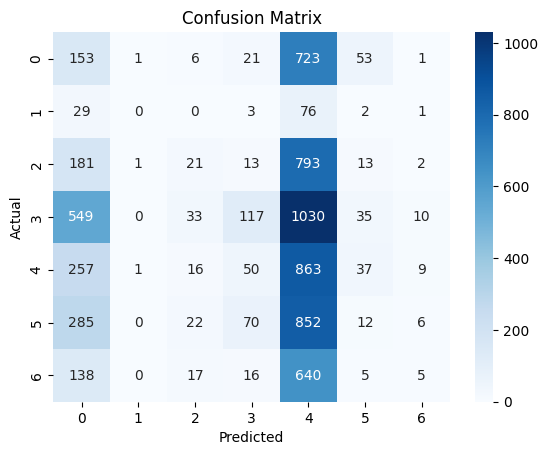

              precision    recall  f1-score   support

           0       0.10      0.16      0.12       958
           1       0.00      0.00      0.00       111
           2       0.18      0.02      0.04      1024
           3       0.40      0.07      0.11      1774
           4       0.17      0.70      0.28      1233
           5       0.08      0.01      0.02      1247
           6       0.15      0.01      0.01       821

    accuracy                           0.16      7168
   macro avg       0.15      0.14      0.08      7168
weighted avg       0.20      0.16      0.10      7168



In [41]:
# Post-training metrics and analysis
# model.load_state_dict(torch.load('sjcnn_final.pth', map_location=device))
# model.load_state_dict(torch.load(os.path.join(save_dir, 'best_model.pth')))
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        y_true.extend(target.cpu().numpy())
        y_pred.extend(output.argmax(dim=1).cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print(classification_report(y_true, y_pred))